# Evaluation of Alaska Dataset

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import string

In [2]:
def get_entities(xlsx):
    return dict([(s, xlsx.parse(s)) for s in xlsx.sheet_names])

def tokenize(s):
    tokens = []
    for candidate in s.split():
        for c in candidate.split('_'):
            k = "".join([x for x in c if c not in string.punctuation]).lower()
            tokens.append(k)
    return tokens

In [3]:
D = get_entities(pd.ExcelFile('top_n_alaska.xlsx'))

In [4]:
targets = {}
for k, data in D.items():
    targets[k] = tokenize(data.target[0])

In [5]:
k = 6
benchmark = ['tfidf_term', 'summary_term', 'glove_term', 'bert_term']
predictions = []
for tool in benchmark:
    p = dict([(e, [tokenize(x) for x in data.iloc[:6][tool].values]) for e, data in D.items()])
    predictions.append(p)

## Precision and recall at k

In [6]:
def stats_at_k(y_true, y_pred):
    yt = set(y_true)
    precision, recall = [], []
    buffer = set()
    for data in y_pred:
        buffer = buffer.union(set(data))
        tp = len(yt.intersection(buffer))
        fp = len(buffer.difference(yt))
        fn = len(yt.difference(buffer))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

In [7]:
outp, outr = {}, {}
for i, tool in enumerate(benchmark):
    P, R = [], []
    for entity, y_true in targets.items():
        y_pred = predictions[i][entity]
        p, r = stats_at_k(y_true, y_pred)
        P.append(p)
        R.append(r)
    outp[tool] = np.array(P)
    outr[tool] = np.array(R)

## Visualize

In [13]:
import matplotlib.pyplot as plt

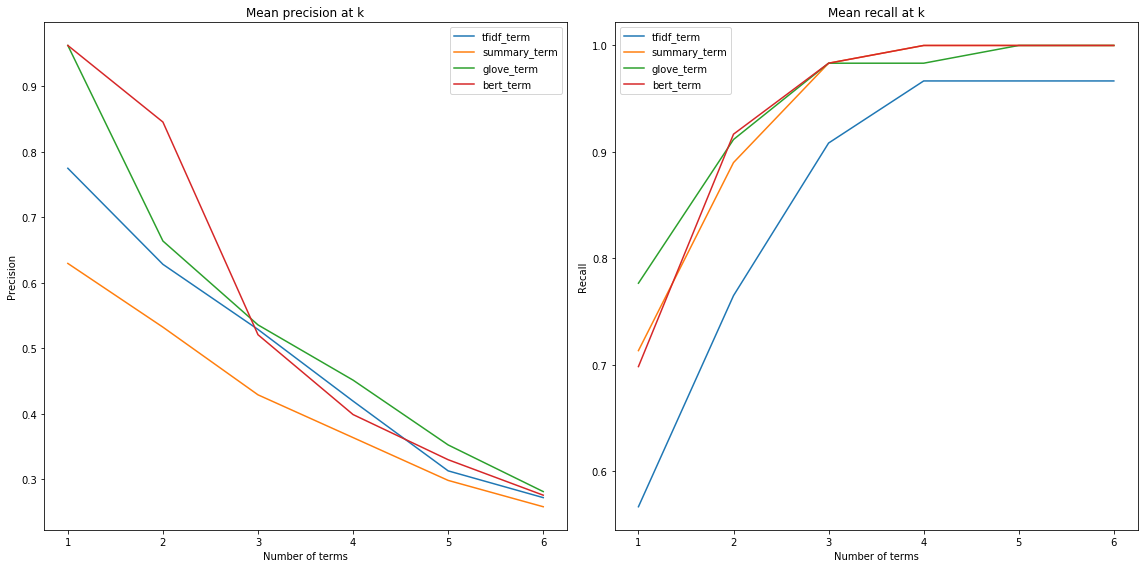

In [21]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
for tool in benchmark:
    ax[0].plot(outp[tool].mean(axis=0), label=tool)
    ax[1].plot(outr[tool].mean(axis=0), label=tool)
ax[0].set_title('Mean precision at k')
ax[1].set_title('Mean recall at k')
ax[0].set_xlabel('Number of terms')
ax[1].set_xlabel('Number of terms')
ax[0].set_ylabel('Precision')
ax[1].set_ylabel('Recall')
ax[0].set_xticklabels(range(0,7))
ax[1].set_xticklabels(range(0,7))

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('prec_rec_atk.pdf')
plt.show()

In [12]:
outp['tfidf_term'].mean(axis=0)

array([0.775     , 0.62833333, 0.52892774, 0.41952131, 0.31301088,
       0.27215659])